In [1]:
import pandas as pd
import numpy as np
import hashlib
from rdkit import Chem
from rdkit.Chem import AllChem
from metatlas import make_df_with_molecules_from_csv, xyzfile_to_psi4mol
from tqdm import tqdm_notebook as tqdm
import psi4

CSV_FILE = 'chebi_and_metacyc_molecules.csv'
molecules = make_df_with_molecules_from_csv(CSV_FILE, reset=False)

### Types of data that people would want to learn on

- Protonation energies for all non-H atoms. 
- 


In [2]:
""" If you want to draw SVGs """
import pybel
import xml.etree.ElementTree as ET
from IPython.display import SVG, HTML

def draw_svg(pymol):
    """ molclone should be the 'clone' property of a pybel.Molecule"""
    namespace = "http://www.w3.org/2000/svg"
    ET.register_namespace("", namespace)
    obsvg = pymol.clone.write("svg")
    tree = ET.fromstring(obsvg)
    svg = tree.find("{{{ns}}}g/{{{ns}}}svg".format(ns=namespace))
    return SVG(ET.tostring(svg).decode("utf-8"))

""" If you want to draw html renderings"""
import imolecule

def draw_html(pymol):
    return HTML(imolecule.draw(pymol.clone, 
                               format="pybel", 
                               display_html=False))

""" These two imports required for in-notebook RDKit plotting"""
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing

## RDKit and/or OpenBabel do suspicious things

For some SMILES strings (luckily for me, the very first in the CSV), RDKit has a difficult time generating 3D conformers which are necessary for beginning our optimization process.

I noticed this because as I tried to automate making 3D coordinates for optimization, the first row in the CSV took an extraordinarily long time attempting to generate a conformer. I started to investigate and saw that it actually doesn't return a 3D conformer at all, which is very much an issue.

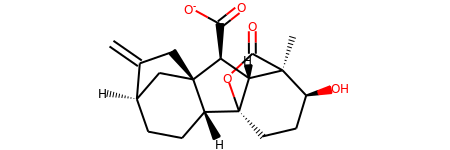

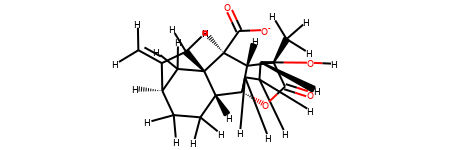

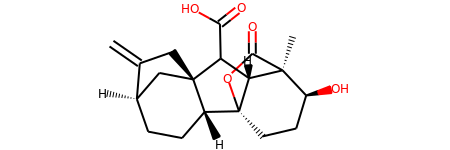

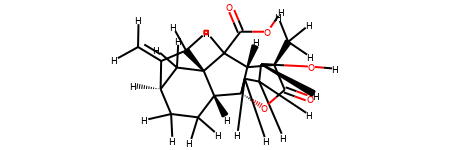

In [12]:
ogsmile = molecules.loc[0, 'original_smiles']
sanismile = molecules.loc[0, 'sanitized_smiles']

rdkit_ogsmile = Chem.MolFromSmiles(ogsmile)
display(rdkit_ogsmile)
rdkit_ogsmile = Chem.AddHs(rdkit_ogsmile)
display(rdkit_ogsmile)

rdkit_sanismile = Chem.MolFromSmiles(sanismile)
display(rdkit_sanismile)
rdkit_sanismile = Chem.AddHs(rdkit_sanismile)
display(rdkit_sanismile)

Chem.MolToMolFile(rdkit_sanismile, 'mol0.mol')

In [16]:
draw_html(pybel.readfile('mol', 'mol0.mol').next())

Molecule: 1-linoleoyl-2-oleoyl-phosphatidylcholine


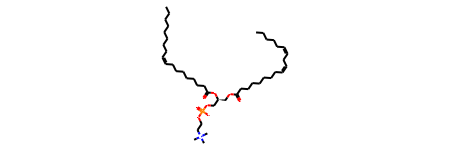

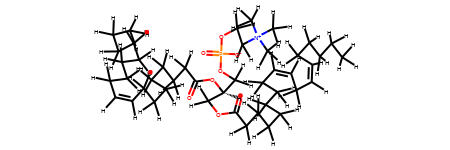

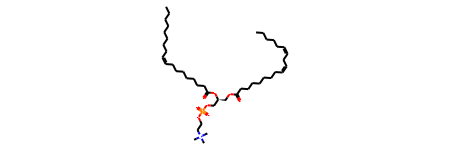

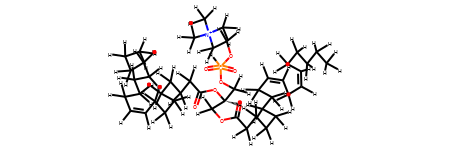

In [21]:
idx = 19
print "Molecule: {}".format(molecules.loc[idx, 'name'])
ogsmile = molecules.loc[idx, 'original_smiles']
sanismile = molecules.loc[idx, 'sanitized_smiles']

rdkit_ogsmile = Chem.MolFromSmiles(ogsmile)
display(rdkit_ogsmile)
rdkit_ogsmile = Chem.AddHs(rdkit_ogsmile)
display(rdkit_ogsmile)

rdkit_sanismile = Chem.MolFromSmiles(sanismile)
display(rdkit_sanismile)
rdkit_sanismile = Chem.AddHs(rdkit_sanismile)
display(rdkit_sanismile)

Chem.MolToMolFile(rdkit_sanismile, 'mol19.mol')

In [18]:
draw_html(pybel.readfile('mol', 'mol19.mol').next())

### An example of a SMILES -> rdkit.molecule that has an acceptable 3d conformer generated

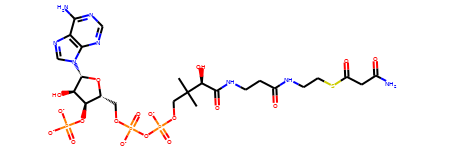

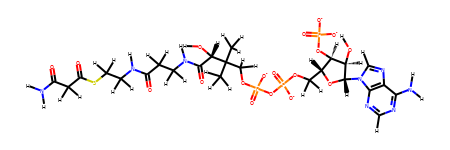

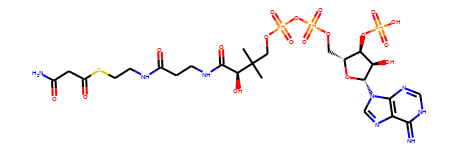

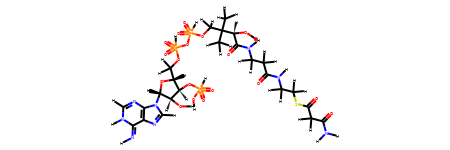

In [19]:
idx = 1
ogsmile = molecules.loc[idx, 'original_smiles']
sanismile = molecules.loc[idx, 'sanitized_smiles']

rdkit_ogsmile = Chem.MolFromSmiles(ogsmile)
display(rdkit_ogsmile)
rdkit_ogsmile = Chem.AddHs(rdkit_ogsmile)
display(rdkit_ogsmile)

rdkit_sanismile = Chem.MolFromSmiles(sanismile)
display(rdkit_sanismile)
rdkit_sanismile = Chem.AddHs(rdkit_sanismile)
display(rdkit_sanismile)

Chem.MolToMolFile(rdkit_sanismile, 'mol{}.mol'.format(idx))

In [20]:
draw_html(pybel.readfile('mol', 'mol1.mol').next())

## OpenBabel is a little more sane

In [11]:
pymol2d = pybel.readstring('smi', molecules.loc[0, 'original_smiles'])
pymol2d.removeh()
display(draw_html(pymol2d))

pymol2d.addh()
pymol2d.make3D()
# pymol.write('mol', filename='pymol3d.mol', overwrite=True)
display(draw_html(pymol2d))

In [6]:
mol = molecules.loc[0, 'molecule']
m2 = Chem.AddHs(mol)

AllChem.EmbedMolecule(m2)
Chem.MolToMolFile(m2, 'mol.mol')

conf = m2.GetConformer()

ValueError: Bad Conformer Id

In [11]:
for i in tqdm(range(0,23)):
    mol = molecules.loc[i, 'molecule']
    m2 = Chem.AddHs(mol)
    if AllChem.EmbedMolecule(m2) < 0:
        print 'oh no {}'.format(i)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bkrull/bin/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/bkrull/bin/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bkrull/bin/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



oh no 0
oh no 19


KeyError: 'the label [22] is not in the [index]'

In [22]:
Chem.rdMolDescriptors.CalcMolFormula(mol)

'C6H9*2NO3'

In [71]:
mol = molecules.loc[2342, 'molecule']
m2 = Chem.AddHs(mol)

AllChem.EmbedMolecule(m2)
Chem.MolToMolFile(m2, 'mol.mol')

conf = m2.GetConformer()

natoms = m2.GetNumAtoms()
for idx in range(natoms):
    atom = m2.GetAtomWithIdx(idx)
    xyz = conf.GetAtomPosition(idx)
    print 'Index={}, Symbol={}, x={}, y={}, z={}'.format(atom_index, atom.GetSymbol(), xyz.x, xyz.y, xyz.z)

Index=0, Symbol=C, x=11.7451245443, y=-2.21385897352, z=-0.079860744166
Index=0, Symbol=C, x=10.7715101053, y=-1.39105619801, z=-0.912466132819
Index=0, Symbol=C, x=10.6259641126, y=-0.0210668979682, z=-0.274989268983
Index=0, Symbol=C, x=9.17592473084, y=0.402633002677, z=-0.425107105619
Index=0, Symbol=C, x=8.32358325196, y=-0.629453933839, z=0.263730676322
Index=0, Symbol=C, x=7.24313386216, y=-0.0150877119592, z=1.11182386796
Index=0, Symbol=C, x=5.86659514476, y=-0.454354237537, z=0.656950609535
Index=0, Symbol=C, x=5.17210949963, y=0.619864601605, z=-0.161403088276
Index=0, Symbol=C, x=4.13187085756, y=1.34370819702, z=0.644471912606
Index=0, Symbol=C, x=2.7244215202, y=0.901173639159, z=0.335011032236
Index=0, Symbol=C, x=2.39225333017, y=0.979534822413, z=-1.12910818889
Index=0, Symbol=C, x=1.19450162768, y=1.83537825941, z=-1.42888645125
Index=0, Symbol=C, x=0.0251370879645, y=1.57143049871, z=-0.524924075184
Index=0, Symbol=C, x=-0.290729291397, y=0.102847756703, z=-0.3772415

In [ ]:
""" Likely main.py structure """
for index, row in tqdm(molecules.iterrows()):
    if row['molecule']:
        
        
for row in range(df.len-1):
    smi, fname = df.loc[row, 'sanitized_smiles'], df.loc[row, 'formula']+'.xyz'
    mol = psi4_xyzfile_to_psi4mol(smi, fname)
    
    psi4.optimize('pbeh3c/def-svp', molecule=mol)

## Optimizing structures and getting output from psi4

In [2]:
psi4.set_num_threads(8)
psi4.set_variable('print', 5)
mol = xyzfile_to_psi4mol('C3H10NO2+.xyz')

e, wfn = psi4.optimize('pbe/sto-3g', molecule=mol, return_wfn='on')

Optimizer: Optimization complete!


In [7]:
np.asarray(wfn.Fa())

array([[ -1.38071144e+01,  -3.55909463e+00,  -1.22275365e-02, ...,
         -1.10954447e-03,  -7.55402477e-03,  -1.75399797e-01],
       [ -3.55909463e+00,  -1.56737922e+00,  -1.03552557e-01, ...,
         -7.69521509e-03,  -2.18272254e-02,  -1.86141658e-01],
       [ -1.22275365e-02,  -1.03552557e-01,  -1.93280801e-01, ...,
         -4.70209871e-03,  -1.51118265e-02,   4.10220624e-02],
       ..., 
       [ -1.10954447e-03,  -7.69521509e-03,  -4.70209871e-03, ...,
         -2.89303345e-01,  -1.70920461e-01,  -4.04436561e-02],
       [ -7.55402477e-03,  -2.18272254e-02,  -1.51118265e-02, ...,
         -1.70920461e-01,  -2.78607334e-01,  -5.48103121e-02],
       [ -1.75399797e-01,  -1.86141658e-01,   4.10220624e-02, ...,
         -4.04436561e-02,  -5.48103121e-02,  -3.24854422e-01]])